# LSTM Stock Prediction Notebook

## Table of Contents
1. [Introduction](#1-introduction)
2. [Libraries](#2-libraries)  
3. [Data Collection & Preprocessing](#3-data-collection--preprocessing)  
4. [Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-eda)  
5. [Feature Engineering](#5-feature-engineering)
6. [Systematic Feature Selection](#6-systematic-feature-selection)  
7. [LSTM Model Architecture & Data Preparation](#7-lstm-model-architecture--data-preparation)  
8. [Hyperparameter Tuning with KerasTuner](#8-hyperparameter-tuning-with-kerastuner)  
9. [Final Model Training & Evaluation](#9-final-model-training--evaluation)
10. [Results & Diagnostics](#10-results--diagnostics)
11. [Conclusion](#11-conclusion)

## 1. Introduction

## 2. Libraries

In [158]:
# Core Libraries 
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from datetime import datetime

# Machine Learning Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import keras_tuner as kt

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Alpaca Libraries
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

# Statistical Libraries
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf

## 3. Data Collection & Preprocessing

In [196]:
# Load environment variables
load_dotenv()

# Gather data from Alpaca
client = StockHistoricalDataClient(os.getenv('ALPACA_API_KEY'), os.getenv('ALPACA_SECRET_KEY'))
request_params = StockBarsRequest(
    symbol_or_symbols=["SPY"],
    timeframe=TimeFrame.Day,
    start=datetime(2016, 7, 1),
    end=datetime(2025, 7, 1)
)
bars = client.get_stock_bars(request_params)

# Convert to DataFrane
df = bars.df.reset_index()

In [197]:
# Add Datetime index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

Before we can use the historical data, we must account for stock splits. Apple conducted a 4-for-1 stock split with an effective date of August 31 2020. This means for every 1 share an investor owned, they recieved 4, and the stock price was quartered to reflect this.
To correct this, we must
1. divide all historical price data (open, high, low, close) before the split date by the split ratio (4)
2. Multiply all historical volume data before the split date by the split ratio (4) as a lower price typically leads to higher trading volume for the same amount of money. 

# Define the stock split details
split_date_dt = pd.to_datetime('2020-08-31').tz_localize('UTC')
split_ratio = 4.0

# Identify the columns to adjust
price_columns = ['open', 'high', 'low', 'close', 'vwap']
volume_columns = ['volume', 'trade_count']

# Apply the adjustment to all data before the split date
df.loc[df.index < split_date_dt, price_columns] /= split_ratio
df.loc[df.index < split_date_dt, volume_columns] *= split_ratio

print("Data adjusted for stock split on", split_date_dt)

## 4. Exploratory Data Analysis (EDA)

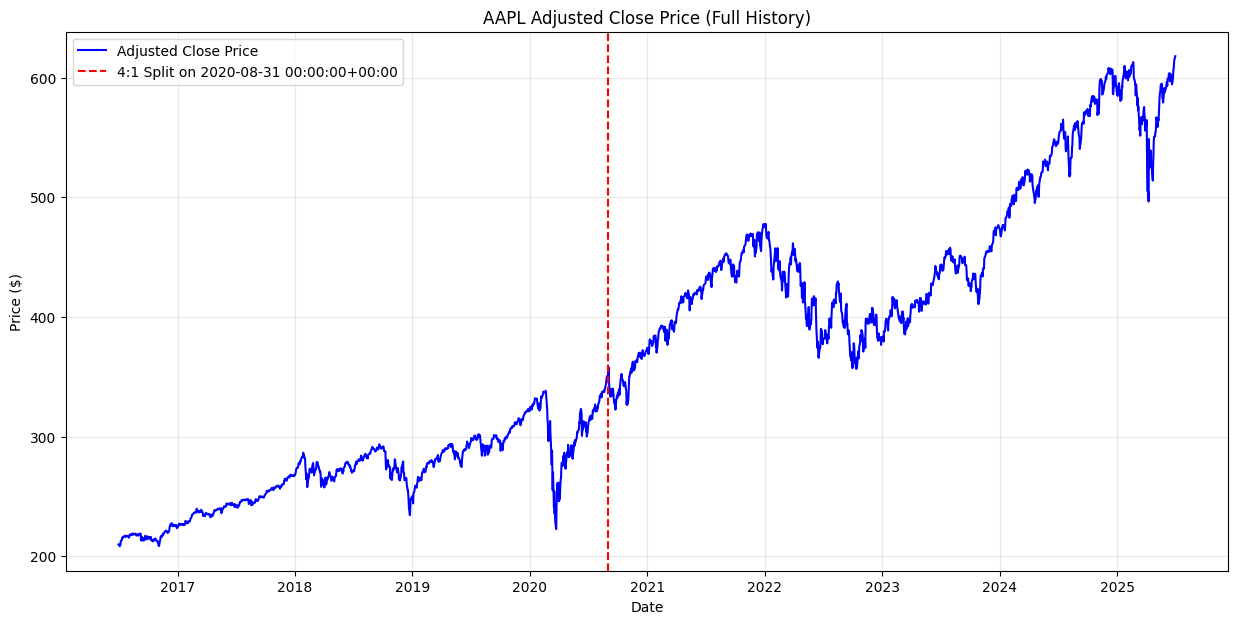

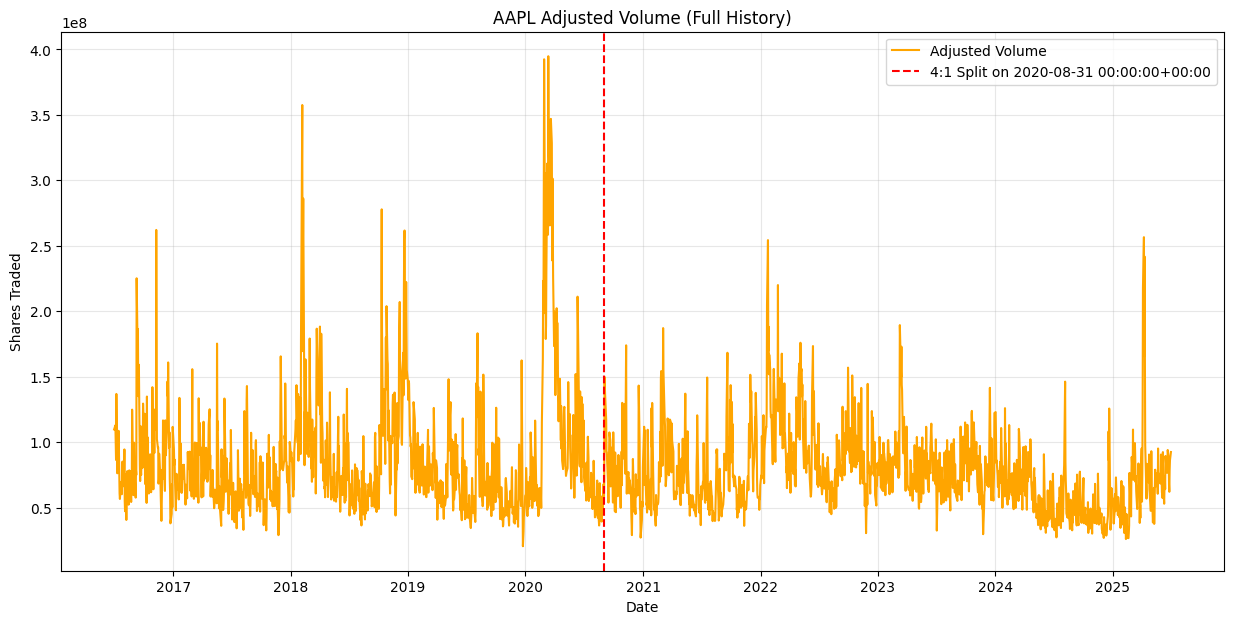

In [198]:
# Plotting the adjusted close price
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close'], label='Adjusted Close Price', color='b')
plt.title('AAPL Adjusted Close Price (Full History)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.axvline(x=split_date_dt, color='r', linestyle='--', label=f'4:1 Split on {split_date_dt}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plotting the adjusted volume
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['volume'], label='Adjusted Volume', color='orange')
plt.title('AAPL Adjusted Volume (Full History)')
plt.xlabel('Date')
plt.ylabel('Shares Traded')
plt.axvline(x=split_date_dt, color='r', linestyle='--', label=f'4:1 Split on {split_date_dt}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [199]:
print("Head of DataFrame:")
print(df.head())
print("\n DataFrame Info:")
print(df.info())

Head of DataFrame:
                          symbol    open  ...  trade_count        vwap
timestamp                                 ...                         
2016-07-01 04:00:00+00:00    SPY  209.36  ...     373381.0  209.978347
2016-07-05 04:00:00+00:00    SPY  208.95  ...     393451.0  208.335900
2016-07-06 04:00:00+00:00    SPY  207.83  ...     394877.0  208.619958
2016-07-07 04:00:00+00:00    SPY  209.87  ...     325106.0  209.589382
2016-07-08 04:00:00+00:00    SPY  211.05  ...     419742.0  212.131147

[5 rows x 8 columns]

 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2261 entries, 2016-07-01 04:00:00+00:00 to 2025-06-30 04:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       2261 non-null   object 
 1   open         2261 non-null   float64
 2   high         2261 non-null   float64
 3   low          2261 non-null   float64
 4   close        2261 non-null   floa

In [200]:
print("\n DataFrame Descriptive Statistics:")
print(df.describe())


 DataFrame Descriptive Statistics:
              open         high  ...   trade_count         vwap
count  2261.000000  2261.000000  ...  2.261000e+03  2261.000000
mean    369.912037   371.974088  ...  4.800738e+05   369.901383
std     110.242753   110.842784  ...  3.301740e+05   110.232034
min     207.830000   209.080000  ...  8.430700e+04   208.335900
25%     275.260000   276.120000  ...  2.750450e+05   274.764848
50%     367.320000   369.620000  ...  4.147380e+05   366.884609
75%     443.550000   445.257200  ...  5.834130e+05   443.289880
max     617.380000   619.220000  ...  3.709929e+06   617.093294

[8 rows x 7 columns]


## 5. Feature Engineering

In this section, we enrich the raw OHLCV (Open, High, Low, Close, Volume) data with meaningful derived features. This is a crucial step, a well-engineered feature set can often provide a more predictive power than a complex model working with raw data. These features are designed to help the LSTM model learn more nuanced temporal patterns beyond just raw price.

### 5.1 Price-Based Features

We begin by generating basic transformations of open, high, low, and close to give the model awareness of price structure and returns.

In [201]:
df["close_lag_1"] = df["close"].shift(1)
df["close_lag_2"] = df["close"].shift(2)
df["close_minus_open"] = df["close"] - df["open"]
df["high_minus_low"] = df["high"] - df["low"]
df["close_over_open"] = df["close"] / df["open"]
df["high_over_low"] = df["high"] / df["low"]
df["daily_return"] = df["close"].pct_change()

### 5.2 Technical Indicators

Here we compute standard indicators used in quantiative analysis, such as moving averages, RSI, MACD, Bollinger Bands, momentum and stochastic oscillators.
- **SMA (Simple Moving Average)**: Average of closing price over a window; helps identify trend direction.
- **EMA (Exponential Moving Average)**: Similar to SMA but gives more weight to recent prices; reacts faster to change.
- **RSI (Relative strength Index)**: Momentum indicator that measures recent gains vs. losses (0-100); detects overbough/oversold conditions.
- **MACD (Moving Average Convergence Divergence)**: Shows the difference between fast & slow EMAs; useful for trend strengnth and reversals.
- **Bollinger Bands**: Bands above/below SMA that expand/contract based on volatility; used to detect price extremes
- **Momentum**: Measures volatility of price changes; helps capture accelerations.
- **Stochastic Oscillator**: Compares closing price to recent highs/lows; signals potential reversals when crossing certain levels.
- **OBV (On-Balance Volume)**: Cumulative Volume that adds on up days and subtracts on down days; used to confirm trends

In [202]:
# Moving Averages
df["SMA_10"] = df["close"].rolling(window=10).mean()
df["SMA_20"] = df["close"].rolling(window=20).mean()
df["EMA_20"] = df["close"].ewm(span=20).mean()
df["EMA_50"] = df["close"].ewm(span=50).mean()

# Volatility
df["volatility_10"] = df["daily_return"].rolling(window=10).std()
df["volatility_20"] = df["daily_return"].rolling(window=20).std()

# RSI (14-day period)
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=df.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=df.index).rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# MACD & Signal Line
EMA_12 = df["close"].ewm(span=12).mean()
EMA_26 = df["close"].ewm(span=26).mean()
df["MACD"] = EMA_12 - EMA_26
df["MACD_signal"] = df["MACD"].ewm(span=9).mean()

# Bollinger Bands
df["BB_upper"] = df["SMA_20"] + (2 * df["close"].rolling(window=20).std())
df["BB_lower"] = df["SMA_20"] - (2 * df["close"].rolling(window=20).std())

# Momentum 
df["momentum_5"] = df["close"] - df["close"].shift(5)

# Stochastic Oscillator 
low_14 = df["low"].rolling(window=14).min()
high_14 = df["high"].rolling(window=14).max()
df["stochastic_14"] = (df["close"] - low_14) / (high_14 - low_14) * 100


### 5.3 Volatility & Rolling Statistics

We use rolling statistics to capture trends in market volatility and relative deviation.

In [203]:
df["rolling_std_5"] = df["close"].rolling(window=5).std()
df["rolling_std_10"] = df["close"].rolling(window=10).std()
df["rolling_std_20"] = df["close"].rolling(window=20).std()

df["rolling_mean_5"] = df["close"].rolling(window=5).mean()
df["rolling_mean_10"] = df["close"].rolling(window=10).mean()
df["rolling_mean_20"] = df["close"].rolling(window=20).mean()

# Z-score
df["zscore_close_10"] = (df["close"] - df["rolling_mean_10"]) / df["rolling_std_10"]

### 5.4 Volume-Based Features

Volume patterns can be strong predictors of price action. Here we include lagged volume, changes, and VWAP deviations.

In [204]:
df["volume_lag_1"] = df["volume"].shift(1)
df["volume_change"] = df["volume"].pct_change()
df["volume_over_rolling_avg_10"] = df["volume"] / df["volume"].rolling(window=10).mean()
df["vwap_diff"] = df["close"] - df["vwap"]
df["vwap_ratio"] = df["close"] / df["vwap"]
df["trade_count_change"] = df["trade_count"].pct_change()

# On-Balance Volume (OBV)
obv = [0] # Initialize OBV list
for i in range(1, len(df)):
    if df['close'][i] > df['close'][i-1]:
        obv.append(obv[-1] + df['volume'][i])
    elif df['close'][i] < df['close'][i-1]:
        obv.append(obv[-1] - df['volume'][i])
    else:
        obv.append(obv[-1])
df['OBV'] = obv

/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_74516/2582677682.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['close'][i] > df['close'][i-1]:
/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_74516/2582677682.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['close'][i] < df['close'][i-1]:
/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_74516/2582677682.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by pos

### 5.5 Statistical Features

These features attempt to extract hidden structures, periodicity, and randomness from the time series - often useful in regime detection, anomaly spotting, and advanced modeling.

- **shannon Entropy**: Measures the degree of randomness in a distribution. High entropy suggests noise or unpredictability, while low entropy implies more structure.
- **Hurst Exponent**: Estimates the long-term memory of a series. A value > 0.5 implies trending behaviour, < 0.5 suggests mean-reverting tendencies, and ~0.5 indicates a random walk.
- **FFT (Fast Fourier Transform)**: Decompose the time series into a sum of sine/cosine waves. Useful for identifying dominant periodicities (cycles).
- **Autocorrelation (Lag 1)**: Measures the correlation between a value and its lagged version. High autocorrelation can indicate persistence or seasonality. 

In [205]:
# Shanon Entropy of Close Price Over a Rolling Window
def shannon_entropy(series, bins=20):
    """Compute the Shannon entropy of a windowed series."""
    hist, _ = np.histogram(series.dropna(), bins=bins, density=True)
    return entropy(hist)

df["shannon_entropy_close"] = df["close"].rolling(window=20).apply(shannon_entropy, raw=False)

# Hurst Exponent Over a Rolling Window
def hurst_exponent(ts):
    """Estimate Hurst exponent of a time series segment."""
    if len(ts) < 20 or ts.isnull().any():
        return np.nan
    lags = range(2, 20)
    try:
        tau = [np.std(ts.values[lag:] - ts.values[:-lag]) for lag in lags]
        log_lags = np.log(lags)
        log_tau = np.log(tau)
        hurst = np.polyfit(log_lags, log_tau, 1)[0]
        return hurst
    except:
        return np.nan

df["hurst_exponent_close"] = df["close"].rolling(window=100).apply(hurst_exponent, raw=False)

# Rolling Autocorrelation (Lag 1 to 3)
df["autocorr_lag_1"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=1)[1], raw=False)
df["autocorr_lag_2"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=2)[2], raw=False)
df["autocorr_lag_3"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=3)[3], raw=False)


Now let's clean up the NaN values and visualise all our features.

In [206]:
# Print head of data
print("Head of DataFrame:")
print(df.head())

print("\n DataFrame Info:")
print(df.info())

print("\n Descriptive Statistics")
print(df.describe())

Head of DataFrame:
                          symbol    open  ...  autocorr_lag_2  autocorr_lag_3
timestamp                                 ...                                
2016-07-01 04:00:00+00:00    SPY  209.36  ...             NaN             NaN
2016-07-05 04:00:00+00:00    SPY  208.95  ...             NaN             NaN
2016-07-06 04:00:00+00:00    SPY  207.83  ...             NaN             NaN
2016-07-07 04:00:00+00:00    SPY  209.87  ...             NaN             NaN
2016-07-08 04:00:00+00:00    SPY  211.05  ...             NaN             NaN

[5 rows x 47 columns]

 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2261 entries, 2016-07-01 04:00:00+00:00 to 2025-06-30 04:00:00+00:00
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   symbol                      2261 non-null   object 
 1   open                        2261 non-null   float64
 2   high  

In [207]:
# Drop initial rows with NaN values
df.dropna(inplace=True)

In [208]:
# Print head of data
print("Head of DataFrame:")
print(df.head())

print("\n DataFrame Info:")
print(df.info())

print("\n Descriptive Statistics")
print(df.describe())

Head of DataFrame:
                          symbol    open  ...  autocorr_lag_2  autocorr_lag_3
timestamp                                 ...                                
2016-11-21 05:00:00+00:00    SPY  219.17  ...        0.686435        0.468802
2016-11-22 05:00:00+00:00    SPY  220.51  ...        0.688031        0.510227
2016-11-23 05:00:00+00:00    SPY  219.98  ...        0.711660        0.522635
2016-11-25 05:00:00+00:00    SPY  221.10  ...        0.724628        0.536351
2016-11-28 05:00:00+00:00    SPY  221.16  ...        0.724397        0.525933

[5 rows x 47 columns]

 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2162 entries, 2016-11-21 05:00:00+00:00 to 2025-06-30 04:00:00+00:00
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   symbol                      2162 non-null   object 
 1   open                        2162 non-null   float64
 2   high  

### 5.6 Feature Visualisation

Now that we've engineered a rich set of features, it's important to visualize them. This helps us understand their distributions, correlations, and relationships with the closing price before feeding them into the model.

#### 5.6.1 Correlation Heatmap
This helps us see which features are most correlated with the 'close' price and identify any multicollinearity between features.

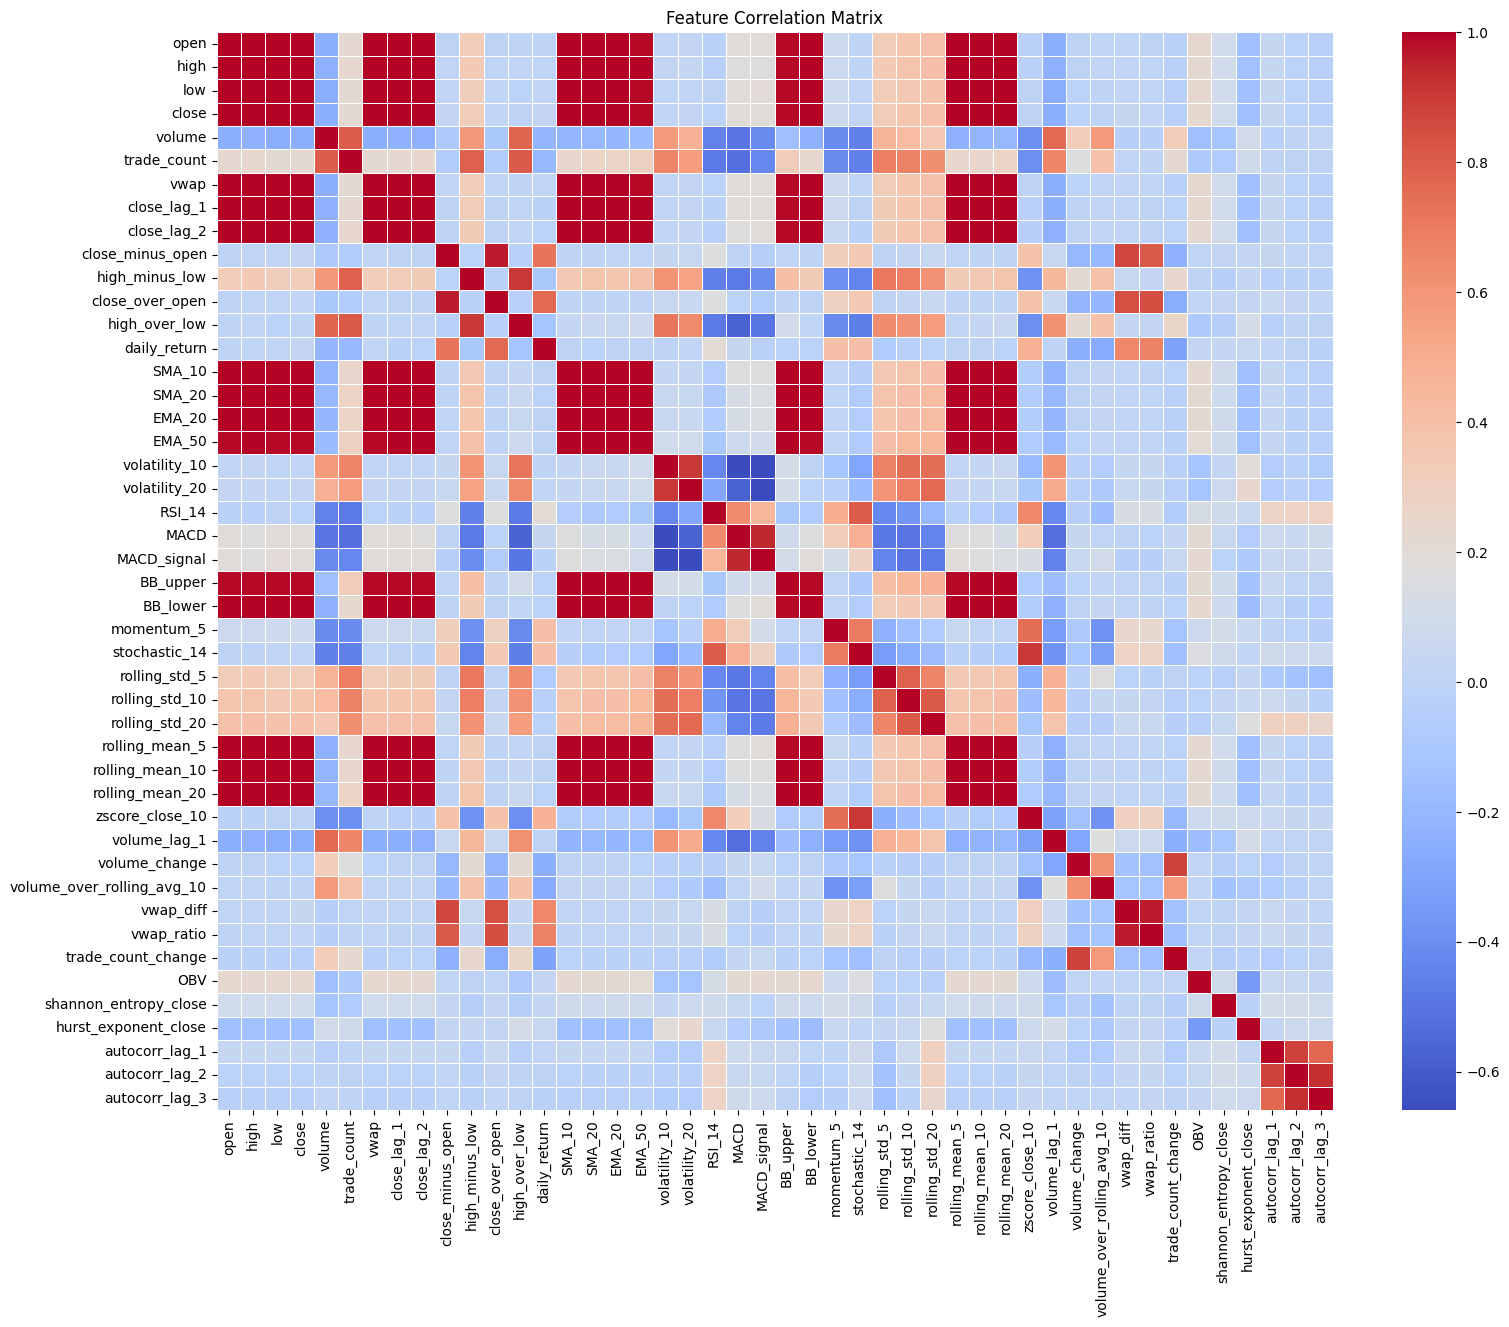


Top 10 features most correlated with 'close' price:
close              1.000000
vwap               0.999882
high               0.999710
low                0.999704
open               0.999480
close_lag_1        0.999170
rolling_mean_5     0.999077
close_lag_2        0.998467
rolling_mean_10    0.997971
SMA_10             0.997971
EMA_20             0.996954
Name: close, dtype: float64


In [209]:
plt.figure(figsize=(18,14))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

print("\nTop 10 features most correlated with 'close' price:")
print(correlation_matrix['close'].abs().sort_values(ascending=False).head(11))

This heatmap gives us a quick overview of how our engineered features relate to each other. The colour scale indicates the strength of the linear correlation, from strong positive (red) to strong negative (blue).
- **High Multicollinearity (Bright Red Blocks):** As expected, price-based features like open, high, low, close, vwap, and all the moving averages are extremely corrclated with each other. This is normal since they are all derived from the price.
- **Informative Indicators:** Features like RSI_14, OBV, and volatility are not perfectly correlated with the close price. This is a good sign, as it suggests they are providing unique information (like momentum, volume pressure, and risk) that isn't captured by the price alone.

#### 5.6.2 Key Indicator Subplots
Plotting indicators like RSI & MACD below the price chart is a good way to visually inspect their behaviour in relation to price movements. We'll plot the last 500 days for clarity

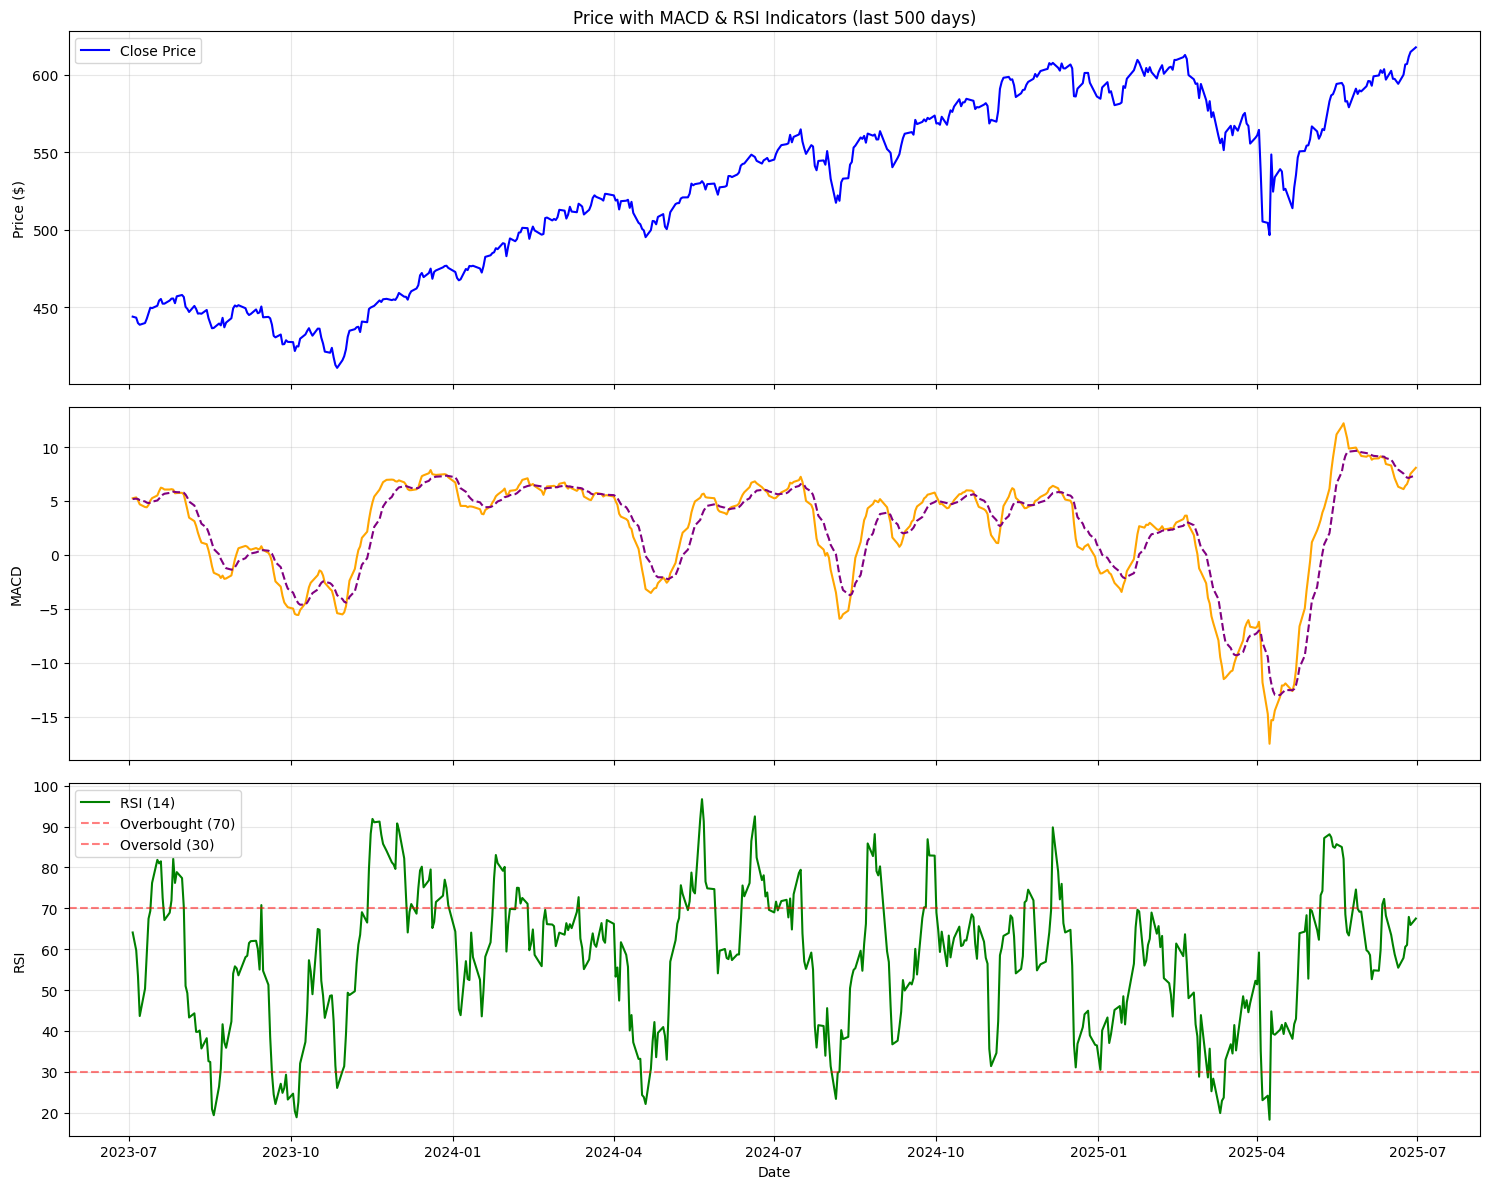

In [210]:
df_plot = df.tail(500)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Price Plot
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='blue')
ax1.set_title('Price with MACD & RSI Indicators (last 500 days)')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MACD Plot
ax2.plot(df_plot.index, df_plot['MACD'], label='MACD', color='orange')
ax2.plot(df_plot.index, df_plot['MACD_signal'], label='Signal Line', color='purple', linestyle='--')
ax2.set_ylabel('MACD')
ax2.grid(True, alpha=0.3)

# RSI Plot
ax3.plot(df_plot.index, df_plot['RSI_14'], label='RSI (14)', color='green')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax3.axhline(30, color='red', linestyle='--', alpha=0.5, label='Oversold (30)')
ax3.set_ylabel('RSI')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 5.6.3 Feature Distribution

Histograms allow us to quickly check the distribution of our engineered features. This is a good check to ensure they fall within expected ranges (e.g., RSI between 0-100) and to spot any unusual skewness or outliers.

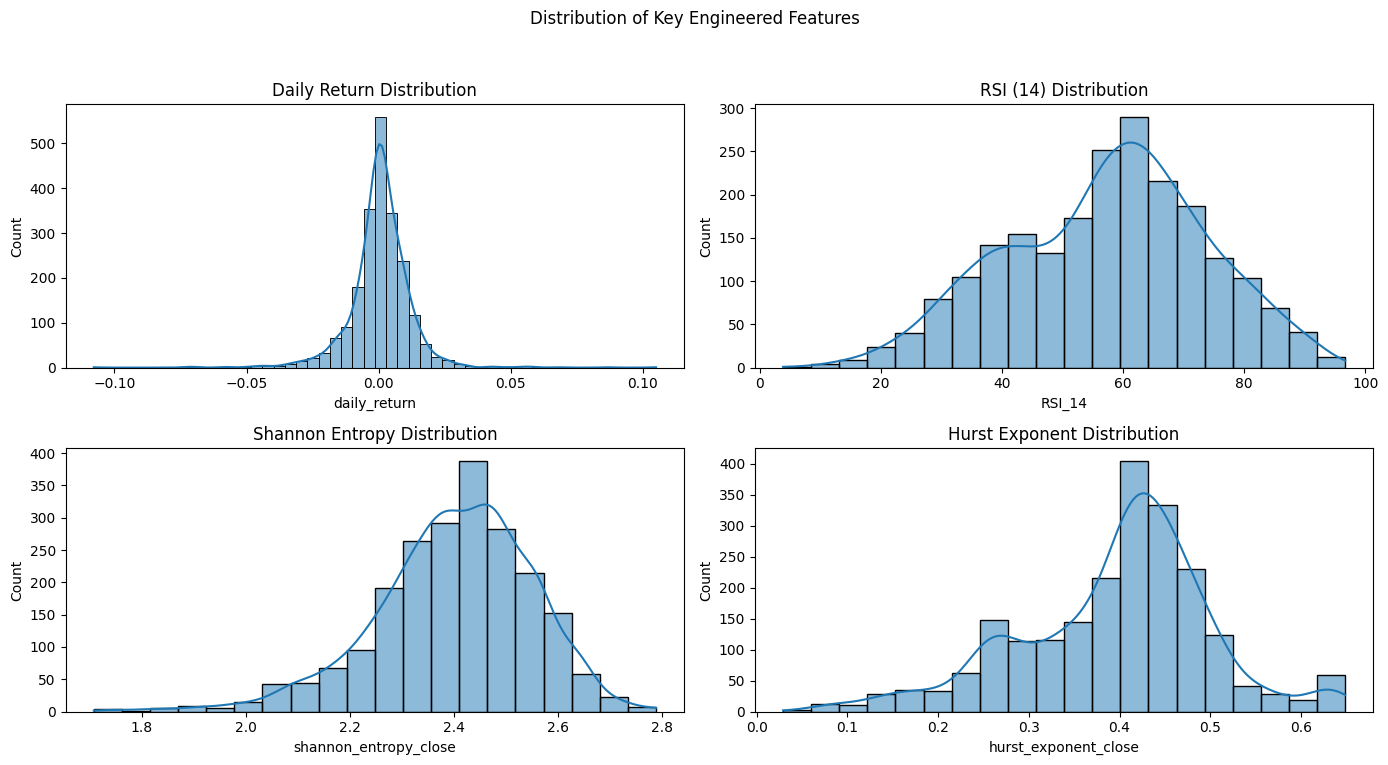

In [211]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Distribution of Key Engineered Features')

# Daily Return
sns.histplot(df['daily_return'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Daily Return Distribution')

# RSI_14
sns.histplot(df['RSI_14'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('RSI (14) Distribution')

# Shannon Entropy
sns.histplot(df['shannon_entropy_close'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Shannon Entropy Distribution')

# Hurst Exponent
sns.histplot(df['hurst_exponent_close'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Hurst Exponent Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Systematic Feature Selection
A large number of features can introduce noise and increase model complexity, sometimes leading to poorer genearlisation (overfitting). To address this and improve our R^2 score, we use a Random Forest Regressor to systematically evaluate the importance of each engineered feature.

The 'feature_importances_' attribute of the Random Forest will provide a score for each feature, indicating its contribution to predicting the target variable (daily return). By selecting the top-performing features, we can train our LSTM on a more focused and powerful dataset.

/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_74516/4131797128.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(25), palette='viridis')


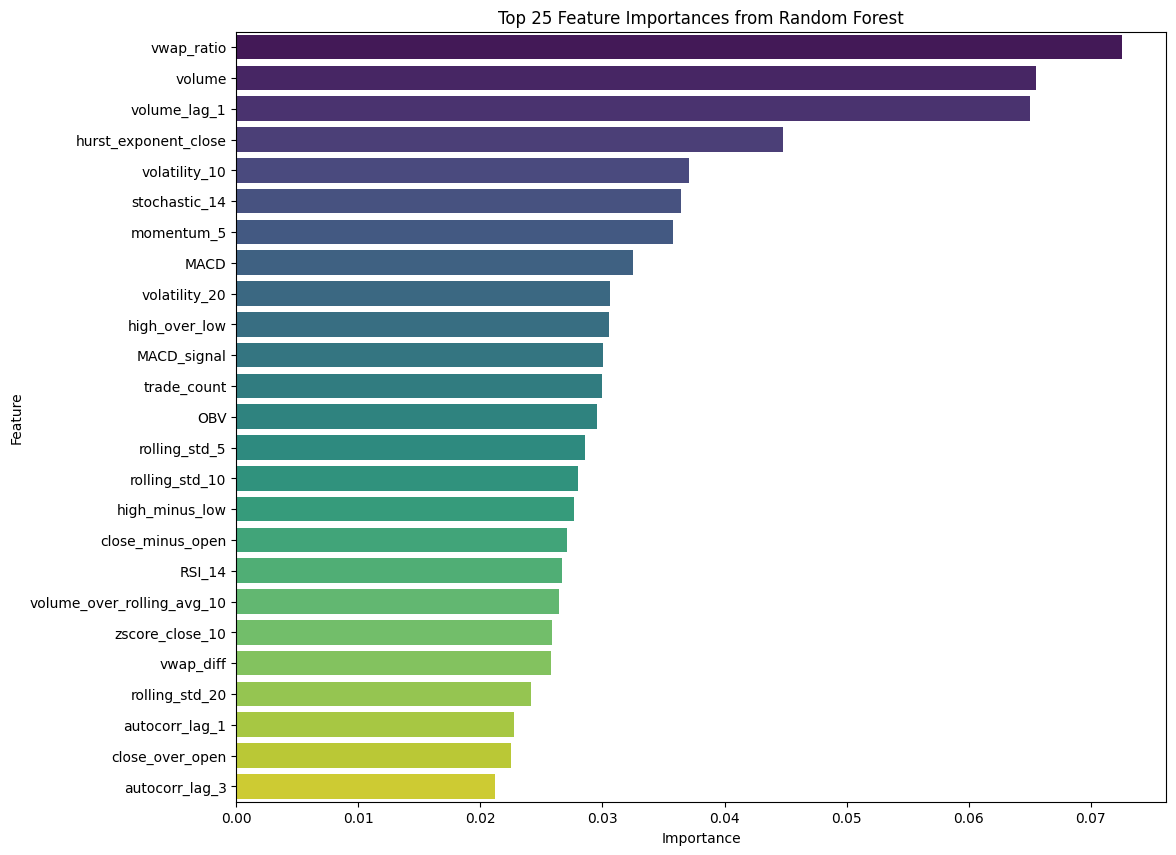


Top 20 Features Selected:
['vwap_ratio', 'volume', 'volume_lag_1', 'hurst_exponent_close', 'volatility_10', 'stochastic_14', 'momentum_5', 'MACD', 'volatility_20', 'high_over_low', 'MACD_signal', 'trade_count', 'OBV', 'rolling_std_5', 'rolling_std_10', 'high_minus_low', 'close_minus_open', 'RSI_14', 'volume_over_rolling_avg_10', 'zscore_close_10']


In [212]:
# Prepare data for Random Forest (it doesn't need sequences)
# shift the target to predict the next day's return
df_rf = df.copy()
df_rf['target_return'] = df_rf['daily_return'].shift(-1)

# Drop the rows with NaNs created by feature engineering and shifting
df_rf.dropna(inplace=True)

# Define features and target for the selection model
X_for_selection = df_rf.drop(columns=['symbol', 'target_return', 'daily_return'])
y_for_selection = df_rf['target_return']

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_for_selection, y_for_selection)

# Extract and plot feature importances
importances = rf_model.feature_importances_
feature_names = X_for_selection.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(25), palette='viridis')
plt.title('Top 25 Feature Importances from Random Forest')
plt.show()

# Select the top N features
N = 20 # Let's select the top 20 features
top_n_features = importance_df.head(N)['Feature'].tolist()

print(f"\nTop {N} Features Selected:")
print(top_n_features)

## 7. LSTM Model Architecture & Data Preparation
With our most predictive features identified, we can now define our LSTM model architecture and prepare the data for it. This involves using the selected features, splitting the data chronologically, scaling it, and reshaping it into the sequences the LSTM can understand.

### 7.1 Data Preparation for LSTM

In [213]:
# Drop non-numeric symbol column
df_model = df.drop(columns=['symbol'])

# Define the features (X) based on our selection and the target (y)
features = top_n_features 
target = 'daily_return'

# Shift the target to predict the next day's return
df_model[target] = df_model[target].shift(-1)

# Drop the last row which now has a NaN target, plus any others from feature engineering
df_model.dropna(inplace=True)

### 7.2 Data Splitting

For time series forecasting, it's important to split the data chronologically. We'll use a fixed number of recent samples for our validation and test sets rather than a percentage-based split. This ensures our test set is always a consistent, recent block of time.

In [214]:
# Define sequence length and split sizes
sequence_length = 60 # Use 60 days of historical data
num_test_samples = 120 # Reserve the last ~6 months for testing 
num_val_samples = 120 # Reserve the ~6 months before 

# Check if there's enough data overall
if len(df_model) < num_test_samples + num_val_samples + sequence_length:
    raise ValueError(f"Not enough data for the specified splits. Need at least {num_test_samples + num_val_samples + sequence_length} samples, but have {len(df_model)}.")

# Split the data into Train, Validation, and Test sets based on fixed sizes from the end
test_split_point = len(df_model) - num_test_samples
val_split_point = test_split_point - num_val_samples

train_df = df_model.iloc[:val_split_point]
val_df = df_model.iloc[val_split_point:test_split_point]
test_df = df_model.iloc[test_split_point:]

print(f"\nDataframe split sizes:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Dataframe split sizes:
Training set size: 1921
Validation set size: 120
Test set size: 120


### 7.3 Data Scaling

We scale the features and target to have a mean of 0 and a standard deviation of 1. This helps the model's optimisation algorithm converge more efficiently. Crucially, we fit the scaler only on the training data to prevent data leakage.

In [215]:
# Initialise scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()    

# Fit scalers ONLY on the training data
feature_scaler.fit(train_df[features])
target_scaler.fit(train_df[[target]])

# Transform the datasets
X_train_scaled = feature_scaler.transform(train_df[features])
y_train_scaled = target_scaler.transform(train_df[[target]])

X_val_scaled = feature_scaler.transform(val_df[features])
y_val_scaled = target_scaler.transform(val_df[[target]])

X_test_scaled = feature_scaler.transform(test_df[features])
y_test_scaled = target_scaler.transform(test_df[[target]])

### 7.4 Sequence Creation

LSTMs require data to be structured into sequences. We create overlapping windows of historical data (60 days of features) to predict the next day's return.

In [216]:
def create_sequences(X, y, sequence_length=60):
    """
    Creates sequences of historical data for time series forecasting.

    This function takes time series feature and target data and transforms
    it into overlapping windows (sequences) suitable for an LSTM model.

    Args:
        features_data (np.array): The array of scaled feature data.
        target_data (np.array): The array of scaled target data.
        sequence_length (int): The number of historical time steps in each sequence.

    Returns:
        tuple[np.array, np.array]: A tuple containing two NumPy arrays:
                                   - The first array contains the input sequences (X).
                                   - The second array contains the corresponding target values (y).
    """
    xs, ys = [], []
    for i in range(len(X) - sequence_length):
        xs.append(X[i:i + sequence_length])
        ys.append(y[i + sequence_length])
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print(f"Shape of training data:X={X_train.shape}, y={y_train.shape}")
print(f"Shape of validation data:X={X_val.shape}, y={y_val.shape}")
print(f"Shape of test data:X={X_test.shape}, y={y_test.shape}")

Shape of training data:X=(1861, 60, 20), y=(1861, 1)
Shape of validation data:X=(60, 60, 20), y=(60, 1)
Shape of test data:X=(60, 60, 20), y=(60, 1)


## 8. Hyperparameter Tuning with KerasTuner

Choosing the right model architecture (e.g., number of layers, neurons per layer) and training parameters (e.g., learning rate) is critical for performance. Instead of guessing, we'll use KerasTuner, a library for systematically finding the optimal set of hyperparameters.

We will use the Hyperband tuner, an efficient algorithm that quickly converges on a high-performing model by intelligently allocating resources to promising hyperparameter combinations.

We will tune the following
- LSTM Units: the number of neurons in the 2 LSTM layers.
- Dropout Rate: the rate of droupout for regularisation.
- Dense Layer Units: the number of neurons in the hidden dense layer.
- Learning Rate: the step size for the Adam optimiser.

In [217]:
def  build_model(hp):
    """Builds and compiles the LSTM model with tunable hyperparameters.

    Args:
        hp (_type_): _description_
    """
    model = keras.models.Sequential()
    
    # Tune the number of units in the first LSTM layer
    hp_units_1 = hp.Int('units_1', min_value=50, max_value=150, step=25)
    model.add(keras.layers.LSTM(units=hp_units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout_1))
    
    # Tune the number of units in the second LSTM layer
    hp_units_2 = hp.Int('units_2', min_value=50, max_value=150, step=25)
    model.add(keras.layers.LSTM(units=hp_units_2, return_sequences=False))
    
    # Tune the dropout rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout_2))
    
    # Tune the number of units in the Dense layer
    hp_units_dense = hp.Int('units_dense', min_value=25, max_value=100, step=25)
    model.add(keras.layers.Dense(units=hp_units_dense, activation='relu'))
    
    
    model.add(keras.layers.Dense(1))  # Output layer for regression
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    
    return model

In [218]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_stock_prediction'
)

/Users/khalid/Desktop/lstm-stock-prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### turn to python to activate, will take a lot of time

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("\n--- Starting Hyperparameter Search ---")

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units are:
LSTM Layer 1: {best_hps.get('units_1')}
LSTM Layer 2: {best_hps.get('units_2')}
Dense Layer: {best_hps.get('units_dense')}

The optimal dropout rates are:
Dropout 1: {best_hps.get('dropout_1'):.2f}
Dropout 2: {best_hps.get('dropout_2'):.2f}

The optimal learning rate is: {best_hps.get('learning_rate')}.
""")

## 9. Final Model Training & Evaluation
Now we build the final model using the optimised hyperparameters found by KerasTuner (or our based architecture if the search was skipped). We train it on the combined training and validation data and then perform a final evaluation on the unseen test set.

### 9.1 Model Training

Build the model with the best hyperparameters: model = tuner.hypermodel.build(best_hps)

or build the initial model if not running the tuner:

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

# Combine training and validation data for the final fit
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

# EarlyStopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150


### 9.2 Performance Evaluation

We use the trained model to make predictions and then inverse scale them to get the predicted daily returns. From these returns, we construct the predicted price path and compare it against the true prices to calculate our final performance metrics.

In [ ]:
# Predict the scaled returns
pred_scaled = model.predict(X_test)

# Inverse transform the predictions to get the real return values
pred_returns = target_scaler.inverse_transform(pred_scaled)

# Get the actual returns for comparison
actual_returns = target_scaler.inverse_transform(y_test)

# Reconstruct the predicted price
test_start_index = len(df_model) - len(X_test) - sequence_length
last_known_prices = df_model['close'].iloc[test_start_index + sequence_length -1 : -1].values
predicted_prices = last_known_prices * (1 + pred_returns.flatten())

# Get the true prices for the test period
true_prices = df_model['close'].iloc[test_start_index + sequence_length:].values

# Evaluate the model on PRICE predictions
mae = mean_absolute_error(true_prices, predicted_prices)
mse = mean_squared_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(true_prices, predicted_prices)
mape = np.mean(np.abs((true_prices - predicted_prices) / true_prices)) * 100

print(f"\nModel Performance on Test Set (Price Prediction):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step

Model Performance on Test Set (Price Prediction):
MAE: 6.5373
MSE: 120.4847
RMSE: 10.9766
R^2: 0.8722
MAPE: 1.18%


## 10. Results & Diagnostics
With the model trained and evaluated, this section provides a visual and statistical assessment of its performance. Diagnostics are crucial for understanding not just what the model predicted, but how it performed, revealing its strengths, weaknesses, and potential areas for further improvement.

### 10.1 Predicted vs. Actual Price Path
This is the most intuitive evaluation. We plot the model's predicted stock prices against the actual prices from the test set. The goal is to see how well the model's predictions track the direction and magnitude of the real price movements.

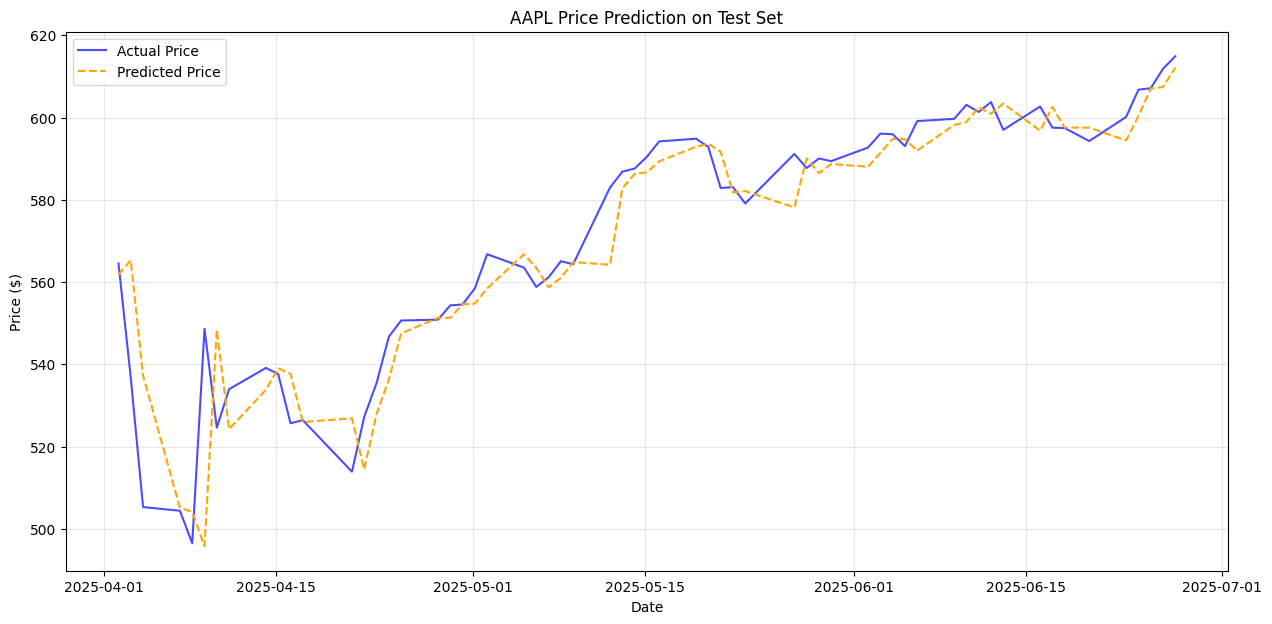

In [ ]:
# Get the dates for the x-axis of the test set plot
test_dates = df_model.index[test_start_index + sequence_length:]

plt.figure(figsize=(15,7))
plt.plot(test_dates, true_prices, label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_dates, predicted_prices, label='Predicted Price', color='orange', linestyle='--')
plt.title('AAPL Price Prediction on Test Set')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Interpretation
Ideally, the orange "Predicted Price" line should closely follow the blue "Actual Price" line. This plot helps to quickly identify if the model is capturing the overall trend, lagging behind, or failing to predict significant price swings.

---

### 10.2 Training & Validation Loss

Plotting the model's loss on the training and validation datasets over each epoch is an important diagnostic for overfitting.

- Training Loss: how well the model is learning from the training data.
- Validation Loss: how well the model generalises to unseen data.

If the training loss continues to decrease while the validation loss flattens out or starts to increase, it's a clear sign of overfitting. Our 'EarlyStopping' callback is designed to stop training at the optimal point before significant overfitting occurs.

*Note: This plot uses the 'history' object from the initial training run where a validation set was used. The final model was retrained on the combined train/val data, so it won't have a 'val_loss'.*

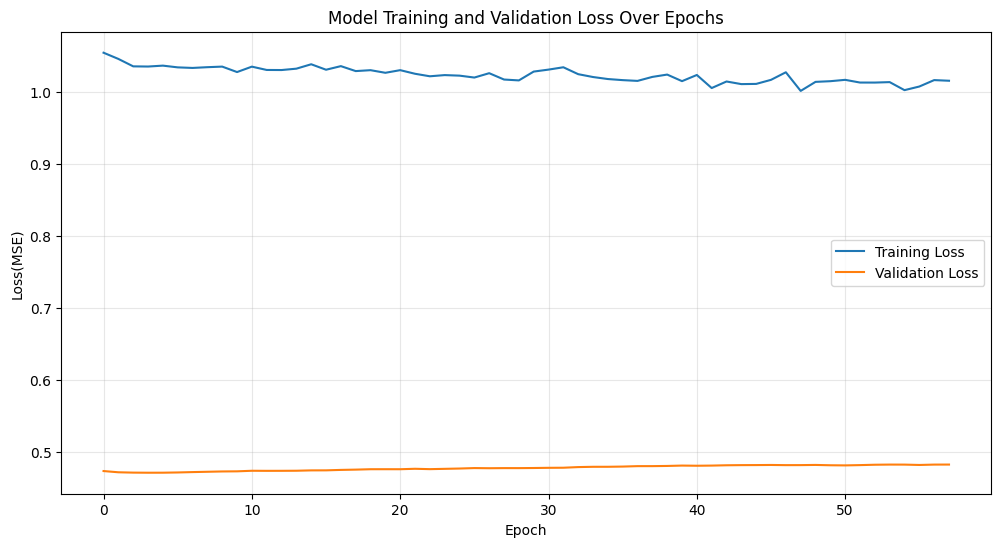

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')

# Check if validation loss is in the history object before plotting
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
plt.title('Model Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss(MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Interpretation
A good training curve shows both training and validation losses decreasing and converging. The gap between the two lines indicates the degree of overfitting. The 'EarlyStopping' callback should have halted the training near the point where the validation loss was at its minimum.

---

### 10.3 Residuals Analysis

Residuals are the errors in our predictions (i.e., 'actual_price - predicted_price'). Analysing them helps us understand if the model has any systematic bias.

1. Residuals over Time: a scatter plot of residuals should look like random noise, with no discernible patterns or trends. If a pattern exists (e.g., errors increase over time), it suggests the model is missing some underlying dynamic.
2. Distribution of Residuals: a histogram of the residuals should ideally resemble a normal distribution (a bell curve) centred around zero. This indicates that the errors are unbiased and random.

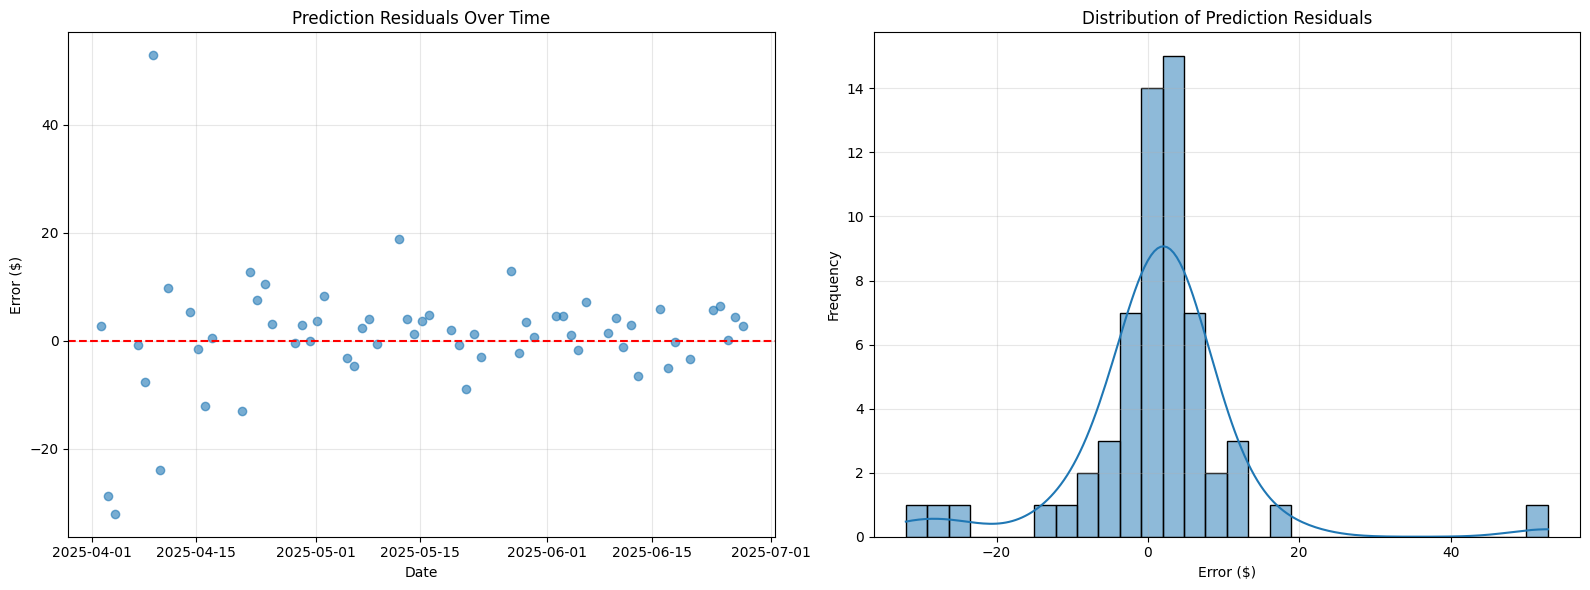


Statistical Summary of Residuals:
count    60.000000
mean      1.176577
std      11.005409
min     -31.993577
25%      -1.502811
50%       1.717569
75%       4.682042
max      52.861969
dtype: float64


In [ ]:
# Calculate residuals
residuals = true_prices - predicted_prices

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Plot residuals over time
ax1.scatter(test_dates, residuals, alpha=0.6)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Prediction Residuals Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Error ($)')
ax1.grid(True, alpha=0.3)

# Plot distribution of residuals
sns.histplot(residuals, bins=30, kde=True, ax=ax2)
ax2.set_title('Distribution of Prediction Residuals')
ax2.set_xlabel('Error ($)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary of residuals
print("\nStatistical Summary of Residuals:")
print(pd.Series(residuals).describe())

## 11. Conclusion

This project has demonstrated a comprehensive workflow for building a sophisticated LSTM-based stock return prediction model. We have moved beyond a simple implementation to create a unique and robust forecasting framework by:
1. Engineering a Rich Feature Set: we augmented the basic OHLCV data with over 40 features, including technical, statistical, and volume-based indicators, providing the model with a much deeper context of the market dynamics.
2. Implementing Systematic Feature Selection: by using a Random Forest Regressor, we were able to quantify the predictive power of each feature. This allowed us to reduce noise and complexity by selecting only the most impactful features, leading to a more focused and potentially more accurate model.
3. Establishing a Hyperparameter Tuning Framework: we integrated KerasTuner with the Hyperband algorithm to create a systematic process for discovering the optimal model architecture and learning rate. This data-driven approach to model design is crucial for maximising performance and moving beyond guesswork. 

### Next Steps and Potential Improvements

## 12. Real-Time Prediction for the Next Trading Day

This final section puts the trained model into practice. The following code fetches the latest available market data, applies the same feature engineering and scaling transformations used for training, and uses the final 60-day sequence to predict the closing price for the next trading day.

In [ ]:
# --- 12. Real-Time Prediction for the Next Trading Day ---

# 1. Define the stock symbol you want to predict
# This MUST match the stock the model was trained on.
prediction_symbol = "SPY"

# 2. Get the last ~250 days of data to ensure a sufficient buffer
end_date = datetime.now()
start_date = end_date - pd.Timedelta(days=250)

request_params = StockBarsRequest(
    symbol_or_symbols=[prediction_symbol],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=None
)
latest_bars = client.get_stock_bars(request_params).df.reset_index()
latest_bars['timestamp'] = pd.to_datetime(latest_bars['timestamp'])
latest_bars.set_index('timestamp', inplace=True)


# 3. --- FULL FEATURE ENGINEERING (MUST MATCH TRAINING SCRIPT) ---
# Price-Based Features
latest_bars["close_lag_1"] = latest_bars["close"].shift(1)
latest_bars["close_lag_2"] = latest_bars["close"].shift(2)
latest_bars["close_minus_open"] = latest_bars["close"] - latest_bars["open"]
latest_bars["high_minus_low"] = latest_bars["high"] - latest_bars["low"]
latest_bars["close_over_open"] = latest_bars["close"] / latest_bars["open"]
latest_bars["high_over_low"] = latest_bars["high"] / latest_bars["low"]
latest_bars["daily_return"] = latest_bars["close"].pct_change()

# Technical Indicators
latest_bars["SMA_10"] = latest_bars["close"].rolling(window=10).mean()
latest_bars["SMA_20"] = latest_bars["close"].rolling(window=20).mean()
latest_bars["EMA_20"] = latest_bars["close"].ewm(span=20).mean()
latest_bars["EMA_50"] = latest_bars["close"].ewm(span=50).mean()
delta = latest_bars["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=latest_bars.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=latest_bars.index).rolling(window=14).mean()
rs = avg_gain / avg_loss
latest_bars["RSI_14"] = 100 - (100 / (1 + rs))
EMA_12 = latest_bars["close"].ewm(span=12).mean()
EMA_26 = latest_bars["close"].ewm(span=26).mean()
latest_bars["MACD"] = EMA_12 - EMA_26
latest_bars["MACD_signal"] = latest_bars["MACD"].ewm(span=9).mean()
latest_bars["BB_upper"] = latest_bars["SMA_20"] + (2 * latest_bars["close"].rolling(window=20).std())
latest_bars["BB_lower"] = latest_bars["SMA_20"] - (2 * latest_bars["close"].rolling(window=20).std())
latest_bars["momentum_5"] = latest_bars["close"] - latest_bars["close"].shift(5)
low_14 = latest_bars["low"].rolling(window=14).min()
high_14 = latest_bars["high"].rolling(window=14).max()
latest_bars["stochastic_14"] = (latest_bars["close"] - low_14) / (high_14 - low_14) * 100

# Volatility & Rolling Statistics
latest_bars["volatility_10"] = latest_bars["daily_return"].rolling(window=10).std()
latest_bars["volatility_20"] = latest_bars["daily_return"].rolling(window=20).std()
latest_bars["rolling_std_5"] = latest_bars["close"].rolling(window=5).std()
latest_bars["rolling_std_10"] = latest_bars["close"].rolling(window=10).std()
latest_bars["rolling_std_20"] = latest_bars["close"].rolling(window=20).std()
latest_bars["rolling_mean_5"] = latest_bars["close"].rolling(window=5).mean()
latest_bars["rolling_mean_10"] = latest_bars["close"].rolling(window=10).mean()
latest_bars["rolling_mean_20"] = latest_bars["close"].rolling(window=20).mean()
latest_bars["zscore_close_10"] = (latest_bars["close"] - latest_bars["rolling_mean_10"]) / latest_bars["rolling_std_10"]

# Volume-Based Features
latest_bars["volume_lag_1"] = latest_bars["volume"].shift(1)
latest_bars["volume_change"] = latest_bars["volume"].pct_change()
latest_bars["volume_over_rolling_avg_10"] = latest_bars["volume"] / latest_bars["volume"].rolling(window=10).mean()
latest_bars["vwap_diff"] = latest_bars["close"] - latest_bars["vwap"]
latest_bars["vwap_ratio"] = latest_bars["close"] / latest_bars["vwap"]
latest_bars["trade_count_change"] = latest_bars["trade_count"].pct_change()
obv = [0]
for i in range(1, len(latest_bars)):
    if latest_bars['close'].iloc[i] > latest_bars['close'].iloc[i-1]:
        obv.append(obv[-1] + latest_bars['volume'].iloc[i])
    elif latest_bars['close'].iloc[i] < latest_bars['close'].iloc[i-1]:
        obv.append(obv[-1] - latest_bars['volume'].iloc[i])
    else:
        obv.append(obv[-1])
if len(obv) == len(latest_bars):
    latest_bars['OBV'] = obv
else: 
    latest_bars['OBV'] = np.nan
    latest_bars['OBV'].iloc[-len(obv):] = obv

# Statistical Features
latest_bars["shannon_entropy_close"] = latest_bars["close"].rolling(window=20).apply(shannon_entropy, raw=False)
latest_bars["hurst_exponent_close"] = latest_bars["close"].rolling(window=100).apply(hurst_exponent, raw=False)
latest_bars["autocorr_lag_1"] = latest_bars["close"].rolling(window=20).apply(lambda x: acf(x, nlags=1)[1], raw=False)

# Drop all NaN values created by the rolling windows
latest_bars.dropna(inplace=True)


# 4. Define the list of features the model was trained on (from your screenshot)
top_n_features = [
    'high_over_low', 'vwap_ratio', 'trade_count', 'volatility_20', 'volatility_10',
    'hurst_exponent_close', 'momentum_5', 'RSI_14', 'trade_count_change',
    'volume_over_rolling_avg_10', 'rolling_std_5', 'MACD', 'zscore_close_10',
    'volume_lag_1', 'stochastic_14', 'vwap_diff', 'rolling_std_10', 'MACD_signal',
    'close_minus_open', 'OBV'
]

# 5. Get the last 'sequence_length' days for prediction
last_sequence = latest_bars[top_n_features].tail(sequence_length).values

# 6. Scale the features using the *already fitted* scaler
last_sequence_scaled = feature_scaler.transform(last_sequence)

# 7. Reshape for the LSTM model
X_predict = np.reshape(last_sequence_scaled, (1, sequence_length, len(top_n_features)))

# 8. Predict the scaled return
predicted_scaled_return = model.predict(X_predict)

# 9. Inverse scale the prediction to get the real return
predicted_return = target_scaler.inverse_transform(predicted_scaled_return)[0][0]

# 10. Get the last known closing price
last_actual_close = latest_bars['close'].iloc[-1]

# 11. Calculate the predicted price for the next day
predicted_price = last_actual_close * (1 + predicted_return)

# --- Display the result ---
print(f"\n--- Prediction for Next Closing Day for {prediction_symbol} ---")
print(f"Last Actual Close Price: ${last_actual_close:,.2f}")
print(f"Predicted Daily Return: {predicted_return:.2%}")
print(f"Predicted Next Close Price: ${predicted_price:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

--- Prediction for Next Closing Day for SPY ---
Last Actual Close Price: $627.97
Predicted Daily Return: 0.40%
Predicted Next Close Price: $630.48


/Users/khalid/Desktop/lstm-stock-prediction/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
